In [58]:
import yfinance as yf
wti = yf.download("CL=F", start="2020-01-01", end="2025-04-12", multi_level_index=False)
copper = yf.download("HG=F", start="2020-01-01", end="2025-04-12", multi_level_index=False)
wti.to_csv("../data/raw/wti_prices.csv")
copper.to_csv("../data/raw/copper_prices.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [59]:
import pandas as pd
wti = pd.read_csv("../data/raw/wti_prices.csv")
wti = wti.dropna()  # Simple cleaning
wti.to_csv("../data/processed/wti_clean.csv")

In [60]:
import pandas as pd
prices = pd.read_csv("../data/processed/wti_clean.csv")
print(prices["Close"].dtype)
print(prices.head())

float64
   Unnamed: 0        Date      Close       High        Low       Open   Volume
0           0  2020-01-02  61.180000  61.599998  60.639999  61.599998   486873
1           1  2020-01-03  63.049999  64.089996  61.130001  61.180000   885861
2           2  2020-01-06  63.270000  64.720001  62.639999  63.709999   724236
3           3  2020-01-07  62.700001  63.150002  62.110001  62.910000   582649
4           4  2020-01-08  59.610001  65.650002  59.150002  62.840000  1205710


In [63]:
# Import libraries
from mesa import Agent, Model
from mesa.time import RandomActivation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Define TraderAgent with logging
class TraderAgent(Agent):
    def __init__(self, unique_id, model, strategy):
        super().__init__(unique_id, model)
        self.strategy = strategy
        self.cash = 100000.0
        self.position = 0
        self.history = {"step": [], "cash": [], "position": []}  # Store results

    def step(self):
        price = self.model.prices[self.model.current_step]
        if self.strategy == "speculator":
            if self.model.current_step > 0:
                prev_price = self.model.prices[self.model.current_step - 1]
                if price > prev_price and self.cash >= price:
                    self.position += 1
                    self.cash -= price
                elif price < prev_price and self.position > 0:
                    self.position -= 1
                    self.cash += price
        # Log data
        self.history["step"].append(self.model.current_step)
        self.history["cash"].append(self.cash)
        self.history["position"].append(self.position)

# Define WTIMarketModel
class WTIMarketModel(Model):
    def __init__(self, N, price_data):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.prices = price_data["Close"].astype(float).values
        self.current_step = 0
        for i in range(self.num_agents):
            strategy = np.random.choice(["speculator", "hedger", "arbitrageur"], p=[0.5, 0.3, 0.2])
            agent = TraderAgent(i, self, strategy)
            self.schedule.add(agent)

    def step(self):
        if self.current_step < len(self.prices) - 1:
            self.schedule.step()
            self.current_step += 1

# Load data
prices = pd.read_csv("../data/processed/wti_clean.csv")

# Run model
model = WTIMarketModel(100, prices)
for i in range(len(prices)):
    model.step()

/Users/matthewlouder/Data Science/abm_wti/venv/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


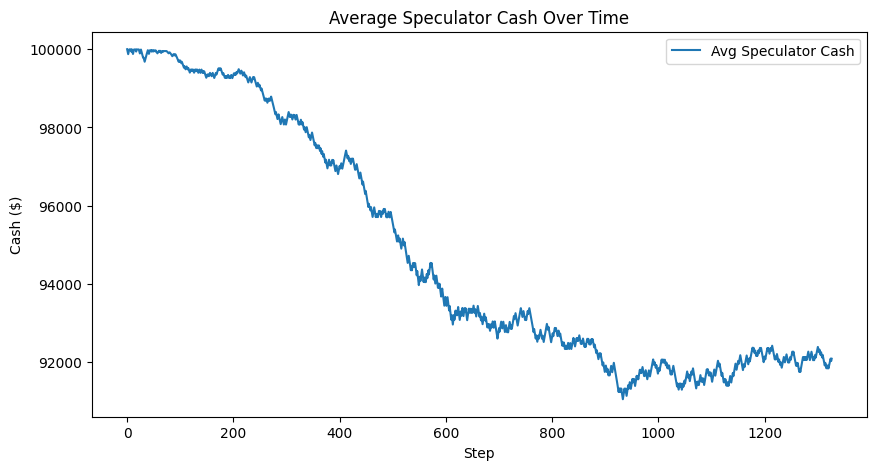

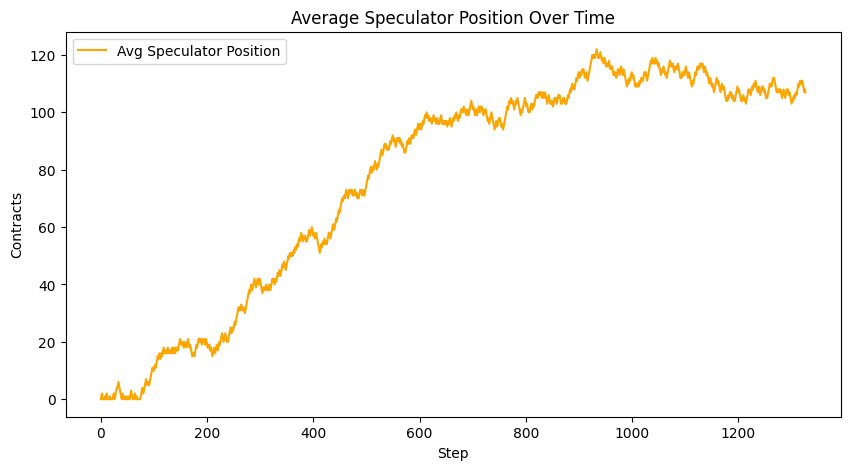

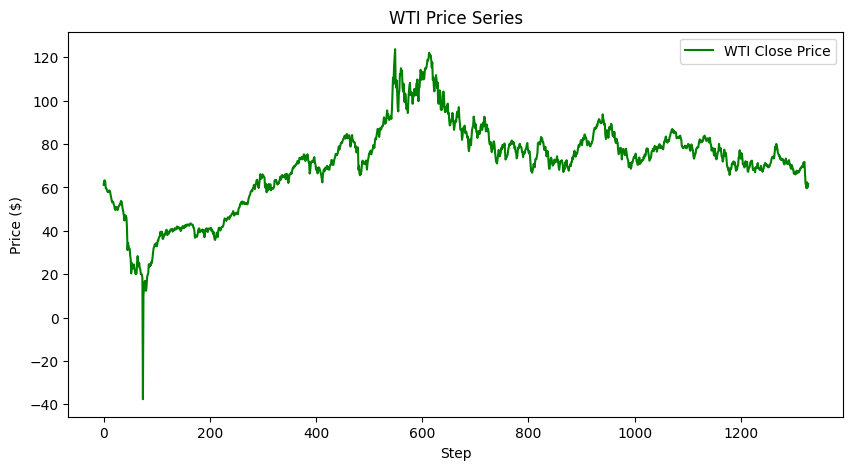

In [64]:
# Extract speculator data
speculators = [agent for agent in model.schedule.agents if agent.strategy == "speculator"]
speculator_cash = pd.DataFrame({
    f"Agent_{agent.unique_id}": agent.history["cash"]
    for agent in speculators
})
speculator_positions = pd.DataFrame({
    f"Agent_{agent.unique_id}": agent.history["position"]
    for agent in speculators
})

# Plot average speculator cash
plt.figure(figsize=(10, 5))
plt.plot(speculator_cash.mean(axis=1), label="Avg Speculator Cash")
plt.title("Average Speculator Cash Over Time")
plt.xlabel("Step")
plt.ylabel("Cash ($)")
plt.legend()
plt.show()

# Plot average speculator positions
plt.figure(figsize=(10, 5))
plt.plot(speculator_positions.mean(axis=1), label="Avg Speculator Position", color="orange")
plt.title("Average Speculator Position Over Time")
plt.xlabel("Step")
plt.ylabel("Contracts")
plt.legend()
plt.show()

# Plot WTI prices for context
plt.figure(figsize=(10, 5))
plt.plot(prices["Close"], label="WTI Close Price", color="green")
plt.title("WTI Price Series")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.show()